In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
pd.set_option("display.max_columns", None)

In [17]:
df_attrition = pd.read_csv("../cortAIx Factory Data Science Technical Test project #1.csv")
df_attrition.head()

,Unnamed: 0,Employee_ID,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,0,0,27.0,Male,Marketing,Manager,New York,9.0,0.586251,151,0,60132,0.0
1,1,1,53.0,Female,Sales,Engineer,New York,10.0,0.261161,221,1,79947,0.0
2,2,2,59.0,Female,Marketing,Analyst,New York,8.0,0.304382,184,0,46958,1.0
3,3,3,42.0,Female,Engineering,Manager,New York,1.0,0.480779,242,0,40662,0.0
4,4,4,44.0,Female,Sales,Engineer,New York,10.0,0.636244,229,1,74307,0.0


In [18]:
df_attrition=df_attrition.iloc[:, 2:]
df_attrition.head()

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,27.0,Male,Marketing,Manager,New York,9.0,0.586251,151,0,60132,0.0
1,53.0,Female,Sales,Engineer,New York,10.0,0.261161,221,1,79947,0.0
2,59.0,Female,Marketing,Analyst,New York,8.0,0.304382,184,0,46958,1.0
3,42.0,Female,Engineering,Manager,New York,1.0,0.480779,242,0,40662,0.0
4,44.0,Female,Sales,Engineer,New York,10.0,0.636244,229,1,74307,0.0


In [58]:
df_attrition.shape

(1005, 11)

In [19]:
df_attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1002 non-null   float64
 1   Gender                 1005 non-null   object 
 2   Department             1003 non-null   object 
 3   Job_Title              1003 non-null   object 
 4   Office_Localisation    1005 non-null   object 
 5   Years_at_Company       1003 non-null   float64
 6   Satisfaction_Level     1005 non-null   float64
 7   Average_Monthly_Hours  1005 non-null   object 
 8   Promotion_Last_5Years  1005 non-null   int64  
 9   Salary                 1005 non-null   int64  
 10  Attrition              1003 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 86.5+ KB


In [20]:
df_attrition.describe()

,Age,Years_at_Company,Satisfaction_Level,Promotion_Last_5Years,Salary,Attrition
count,1002.000000,1003.000000,1005.000000,1005.000000,1005.000000,1003.000000
mean,42.159681,5.788550,0.853978,77.989055,64364.466667,0.493519
std,10.003219,5.038546,7.786145,1758.286034,20707.140455,0.500207
min,25.000000,0.000000,0.001376,0.000000,0.000000,0.000000
25%,33.000000,3.000000,0.261064,0.000000,47576.000000,0.000000
50%,43.000000,6.000000,0.505940,0.000000,64407.000000,0.000000
75%,50.000000,8.000000,0.762460,1.000000,81919.000000,1.000000
max,59.000000,99.000000,177.000000,45124.000000,99991.000000,1.000000


In [23]:
df_attrition.head()

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,27.0,Male,Marketing,Manager,New York,9.0,0.586251,151,0,60132,0.0
1,53.0,Female,Sales,Engineer,New York,10.0,0.261161,221,1,79947,0.0
2,59.0,Female,Marketing,Analyst,New York,8.0,0.304382,184,0,46958,1.0
3,42.0,Female,Engineering,Manager,New York,1.0,0.480779,242,0,40662,0.0
4,44.0,Female,Sales,Engineer,New York,10.0,0.636244,229,1,74307,0.0


# Statistics

## Categorical Data

In [22]:
df_attrition["Gender"].value_counts(normalize=True, dropna=False)

Gender
Male      0.506468
Female    0.493532
Name: proportion, dtype: float64

In [25]:
df_attrition["Department"].value_counts(normalize=True, dropna=False)

Department
Sales          0.208955
Finance        0.205970
Engineering    0.203980
HR             0.190050
Marketing      0.189055
NaN            0.001990
Name: proportion, dtype: float64

In [26]:
df_attrition["Job_Title"].value_counts(normalize=True, dropna=False)

Job_Title
Engineer         0.213930
Accountant       0.206965
Manager          0.203980
Analyst          0.193035
HR Specialist    0.178109
NaN              0.001990
1                0.000995
2                0.000995
Name: proportion, dtype: float64

In [27]:
df_attrition["Office_Localisation"].value_counts(normalize=True, dropna=False)

Office_Localisation
New York    1.0
Name: proportion, dtype: float64

In [29]:
df_attrition["Promotion_Last_5Years"].value_counts(normalize=True, dropna=False)

Promotion_Last_5Years
0        0.515423
1        0.482587
45124    0.000995
32770    0.000995
Name: proportion, dtype: float64

Most categorical data are uniformly distributed, with some of the following issues:
- Missing values in Department
- Missing values in Job_Title
- Outliers in Job_Title (values 1 and 2)
- Outliers in Promotion_Last_5Years (values 45124 and 32770)

In [30]:
mask_categorical = (
    df_attrition["Department"].isnull() |
    df_attrition["Job_Title"].isnull() |
    df_attrition["Job_Title"].isin(["1", "2"]) |
    df_attrition["Promotion_Last_5Years"].isin([45124, 32770])
)

## Numerical Data

In [33]:
# We check for missing values
df_attrition[["Age", "Years_at_Company",
             "Satisfaction_Level", "Average_Monthly_Hours",
             "Salary"]].isnull().sum()

Age                      3
Years_at_Company         2
Satisfaction_Level       0
Average_Monthly_Hours    0
Salary                   0
dtype: int64

In [50]:
# We check for not consistent data
df_attrition[df_attrition["Age"] < df_attrition["Years_at_Company"]]

,Age,Gender,Department,Job_Title,Office_Localisation,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
206,26.0,Female,Engineering,Engineer,New York,99.0,0.870157,168,0,30773,0.0
770,32.0,Male,Engineering,Analyst,New York,99.0,0.471630,163,0,60017,1.0


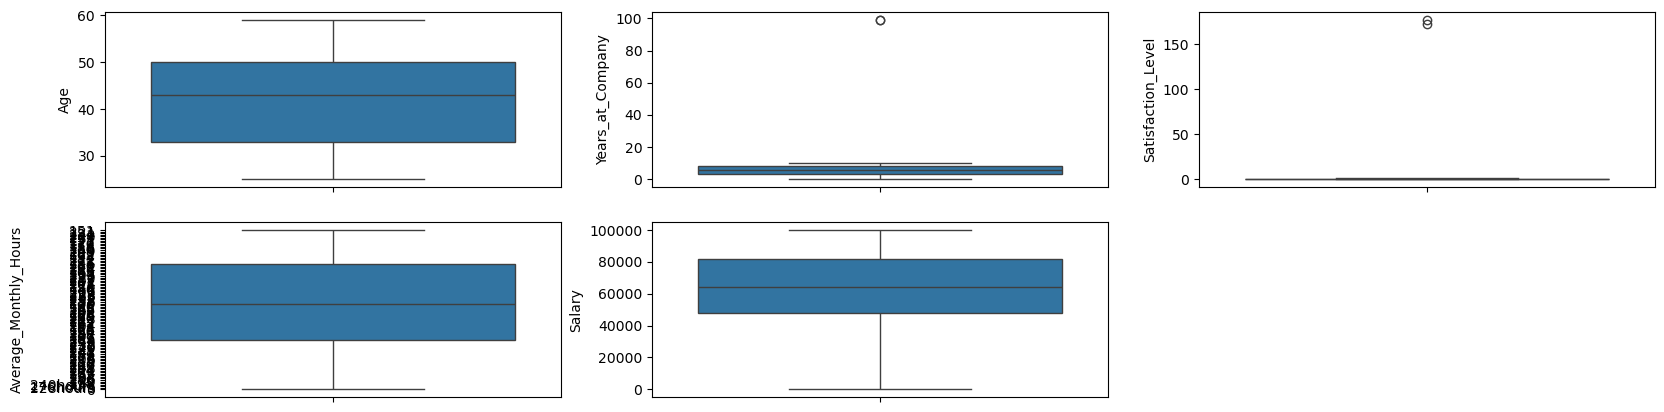

In [46]:
# We check for outliers using boxplot
fig, axes = plt.subplots(2, 3, figsize=(20, 5))
axes[1, 2].remove()
axes = axes.flatten()

for i, col in enumerate(["Age", "Years_at_Company", "Satisfaction_Level",
                        "Average_Monthly_Hours", "Salary"]):
    plt.sca(axes[i])
    sns.boxplot(y=df_attrition[col])

Variables Years_at_Company and Satisfaction_Level present some outliers as seen in the boxplots respectively for over 90 and over 150

In [51]:
mask_numerical = (
    df_attrition["Age"].isnull() |
    df_attrition["Years_at_Company"].isnull() |
    (df_attrition["Age"] < df_attrition["Years_at_Company"]) |
    (df_attrition["Years_at_Company"] > 90) |
    (df_attrition["Satisfaction_Level"] > 150)
)

## Target

In [36]:
df_attrition["Attrition"].value_counts(normalize=True, dropna=False)

Attrition
0.0    0.505473
1.0    0.492537
NaN    0.001990
Name: proportion, dtype: float64

The data is not imbalanced, we will not need to use techniques like SMOTE or ADASYN, or change the losses of the classification algorithms.

However, the target has some missing values.

In [38]:
mask_target = df_attrition["Attrition"].isnull()

## Dealing with missing values and outliers

In [53]:
len(df_attrition[mask_categorical | mask_numerical | mask_target])/len(df_attrition)

0.010945273631840797